<a href="https://colab.research.google.com/github/GwonHayeon/deeplearning_pytorch/blob/main/ch6/1.3%20VGGnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#39) 필요한 라이브러리 호출
import copy #객체 복사를 위해 사용. 객체는 크게 얕은 복사와 깊은 복사로 나뉨
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#40) VGG모델 정의
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features #VGG 모델에 대한 매개변수에서 받아 온 features 값을 self.features에 넣어준다
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim)
        ) #완전연결층과 출력층 정의

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0],-1)
        x = self.classifier(h)
        return x,h

In [ ]:
#41)모델 유형 정의
vgg11_config = [64, 'M', 128, 'M',256,256,'M',512,512,'M',512,512,'M'] #8(합성곱층)+3(풀링층)=11(전체계층)
vgg13_config = [64, 64, 'M', 128,128, 'M',256,256,'M',512,512,'M',512,512,'M'] #10(합성곱층)+3(풀링층)=13(전체계층)
vgg16_config = [64, 64, 'M', 128,128, 'M',256,256,256,'M',512,512,512,'M',512,512,512,'M'] #13(합성곱층)+3(풀링층)=16(전체계층)
vgg19_config = [64, 64, 'M', 128,128, 'M',256,256,256,256,'M',512,512,512,512,'M',512,512,512,512,'M'] #16(합성곱층)+3(풀링층)=19(전체계층)

In [ ]:
#42) VGG 계층 정의
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c,int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding=1)
            if batch_norm: #배치 정규화를 적용할지에 대한 코드
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)] #배치정규화가 적용될 경우 배치 정규화 적용
            else :
                layers += [conv2d, nn.ReLU(inplace=True)] #배치정규화가 적용되지 않을 경우 ReLU만 적용
            in_channels = c

    return nn.Sequential(*layers)

In [ ]:
#43) 모델 계층생성
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

In [ ]:
#44) VGG11 계층확인
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [ ]:
#45) VGG11 전체에 대한 네트워크
OUTPUT_DIM = 2 #개와 고양이 두 개의 클래스 사용
model = VGG(vgg11_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
#46)VGG11 사전 훈련된 모델 사용
import torchvision.models as models
pretrained_model = models.vgg11_bn(pretrained=True) #배치정규화가 적용된 사전 훈련된 VGG11 모델을 사용하기 위해서는 다음과 같은 파라미터사용
# vgg11_bn : 기본모델에 배치 정규화가 적용된 모델 사용
# pretrained를 True로 설정하면 사전 훈련된 모델을 사용

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:07<00:00, 73.8MB/s]


In [ ]:
#47) 이미지 데이터 전처리
train_transforms = transforms.Compose([
                        transforms.Resize((256,256)),
                        transforms.RandomRotation(5),
                        transforms.RandomHorizontalFlip(0.5),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])
test_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225])])

In [ ]:
#48) 데이터셋 불러오기
train_path = '/content/drive/MyDrive/Colab Notebooks/ch6 data/catanddog/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/ch6 data/catanddog/test'

train_dataset = torchvision.datasets.ImageFolder(train_path, transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform=test_transforms)

print(len(train_dataset)), print(len(test_dataset))

529
12


(None, None)

In [ ]:
#49) 훈련과 검증 데이터 분할
VALID_RATIO = 0.9
n_train_examples = int(len(train_dataset) * VALID_RATIO) #전체 데이터 중 90%를 훈련 데이터셋으로 이용
n_valid_examples = len(train_dataset) - n_train_examples #전체 데이터 중 10%를 검증 데이터셋으로 사용

train_data, valid_data = data.random_split(train_dataset, [n_train_examples, n_valid_examples])

In [ ]:
#50) 검증 데이터 전처리
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [ ]:
#51) 훈련, 검증, 테스트 데이터셋 수 확인
print(f'Number of training examples : {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples : {len(test_dataset)}')

Number of training examples : 476
Number of validation examples: 53
Number of testing examples : 12


In [ ]:
#52) 메모리로 데이터 불러오기
BATCH_SIZE = 128
train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE) #훈련 데이터셋은 임의로 섞어서 가져옴
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
#53) 옵티마이저 손실함수 정의
optimizer = optim.Adam(model.parameters(),lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
#54) 모델 정확도 측정함수
def calculate_accuracy(y_pred,y):
    top_pred = y_pred.argmax(1,keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum() #예측과 정답이 일치하는 경우 그 개수 합을 correct 변수에 저장
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
#55)  모델 학습 함수 정의
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for(x,y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
#56) 모델 성능 측정 함수
def evaluate(model, iterator, criterion, device) :
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for(x,y) in iterator :
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
#57) 학습시간 측정 함수
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
#58) 모델학습
import time
EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(EPOCHS) :
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device) #훈련 데이터셋을 모델에 적용한 결과를 train_loss와 train_acc에 저장
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    if valid_loss < best_valid_loss: #valid_loss가 가장 작은 값을 구하고 그상태의 모델을 VGG-model.pt 이름으로 저장
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/ch6 data/VGG-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time) #모델 훈련에 대한 시작과 종료 시간 저장

    print(f'Epoch: {epoch+1:02}|Epoch Time:{epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss: .3f}| Train Acc: {train_acc * 100:.2f}%')
    print(f'\tValid. Loss: {valid_loss:.3f}| Valid. Acc: {valid_acc *100:.2f}%')

Epoch: 01|Epoch Time:0m 5s
	Train Loss:  0.701| Train Acc: 49.07%
	Valid. Loss: 0.693| Valid. Acc: 52.83%
Epoch: 02|Epoch Time:0m 4s
	Train Loss:  0.700| Train Acc: 50.58%
	Valid. Loss: 0.693| Valid. Acc: 52.83%
Epoch: 03|Epoch Time:0m 4s
	Train Loss:  0.701| Train Acc: 48.59%
	Valid. Loss: 0.693| Valid. Acc: 49.06%
Epoch: 04|Epoch Time:0m 4s
	Train Loss:  0.695| Train Acc: 50.69%
	Valid. Loss: 0.693| Valid. Acc: 54.72%
Epoch: 05|Epoch Time:0m 4s
	Train Loss:  0.692| Train Acc: 50.15%
	Valid. Loss: 0.693| Valid. Acc: 60.38%


In [ ]:
#59) 테스트 데이터셋을 이용한 모델 성능 측정

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ch6 data/VGG-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f}|Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.693|Test Acc: 50.00%


In [ ]:
#60) 테스트 데이터셋을 이용한 모델의 예측 확인 함수
def get_predictions(model, iterator):
  model.eval()
  images = []
  labels = []
  probs = []

  with torch.no_grad():
    for(x,y) in iterator:
      x=x.to(device)
      y_pred, _ =model(x)
      y_prob, _ =model(x)
      top_pred = y_prob.argmax(1,keepdim=True) # 배열에서 가장 큰 인덱스 탐색
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())

  images = torch.cat(images, dim=0) # 텐서 연결
  labels = torch.cat(labels, dim=0)
  probs = torch.cat(probs, dim=0)
  return images, labels, probs

In [ ]:
#61) 예측 중에서 정확하게 예측한 것을 추출
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs,1)
corrects = torch.eq(labels, pred_labels) #예측과 정답이 같은지 비교
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects): #여러개의 리스트를 합쳐서 새로운 튜플 타입으로 반환
  if correct:
    correct_examples.append((image, label, prob))

#데이터정렬. 내림차순으로 lambda (매개변수):(반횐될 결괏값)
correct_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

In [ ]:
#62) 이미지 출력을 위한 전처리
#앞서 이미지 크기 및 전처리 과정을 거쳤어서 이미지 출력하면 왜곡되므로 전처리필요
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min=image_min, max=image_max)
  image.add_(-image_min).div_(image_max-image_min+1e-5) #새로운 공간 할당 없이 기존의 메모리에 값 대체
  return image

In [ ]:
#63) 모델이 정확하게 예측한 이미지 출력 함수
from matplotlib import pyplot as plt
def plot_most_correct(correct, classes, n_images, normalize=True):
  rows = int(np.sqrt(n_images)) #np.sqrt는 제곱근을 계산(0.5를 거듭제곱)
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize=(25,20))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image, true_label, probs = correct[i]
    image = image.permute(1,2,0) #축을 변경할 때 사용
    true_prob = probs[true_label]
    correct_prob, correct_label = torch.max(probs, dim=0)
    true_class = classes[true_label]
    correct_class = classes[correct_label]

    if normalize:
      image = normalize_image(image)

    ax.imshow(image.cpu().numpy())
    ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n pred label:{correct_class} ({correct_prob:.3f})')
    ax.axis('off')

  fig.subplots_adjust(hspace=0.4)

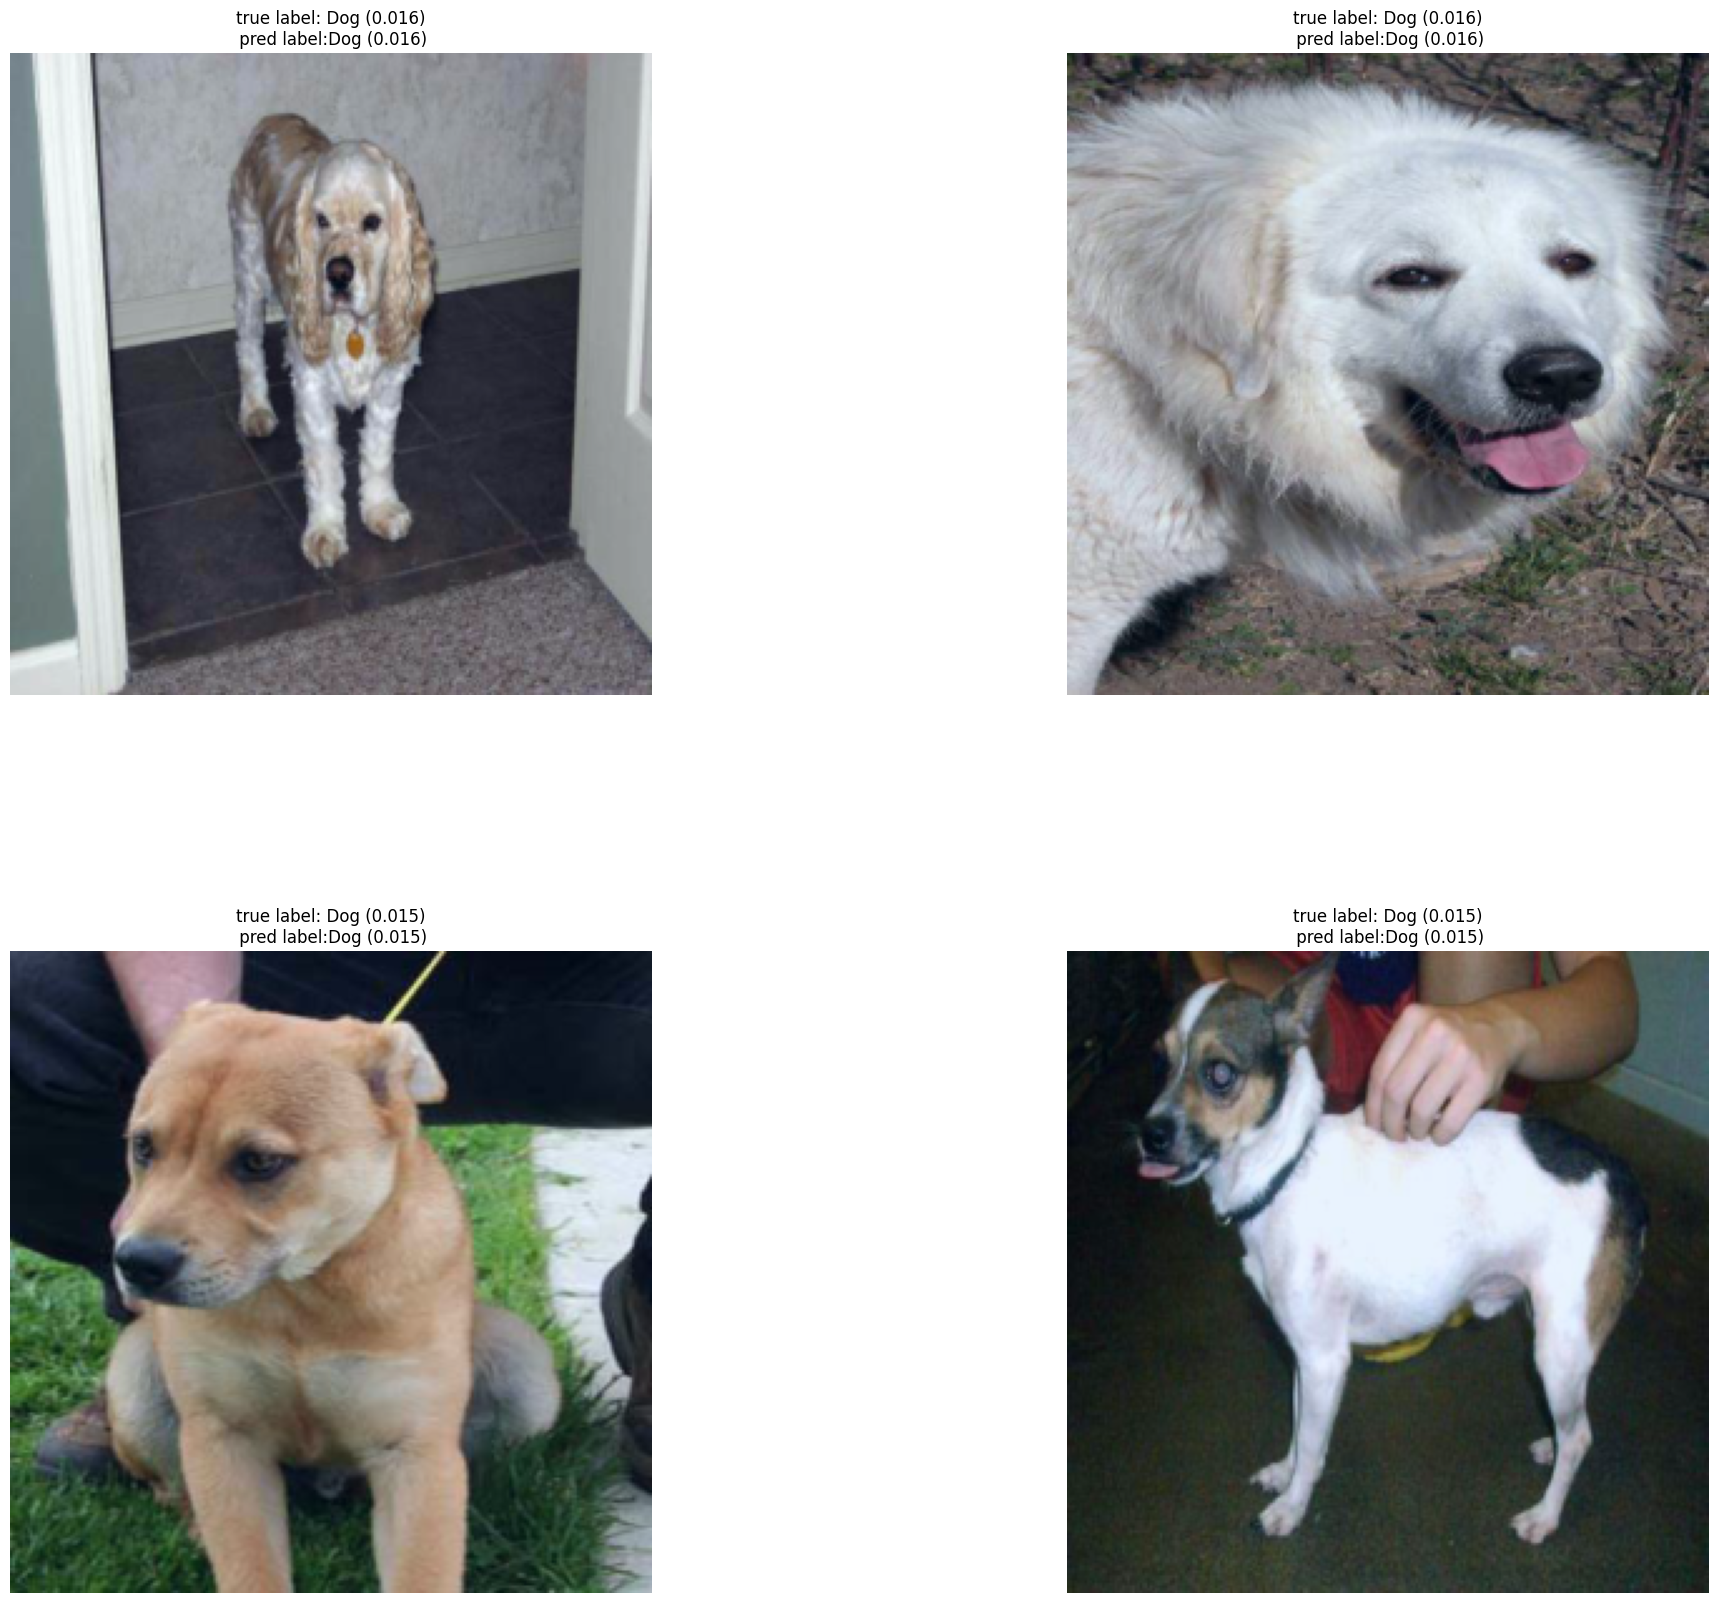

In [ ]:
#64) 예측 결과 이미지 출력
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)